# CryptoProphet
## Notebook's Goal
> > Train and assess results of XGBoost Regression model over Text Embeddings and Technical Analysis KPI's

In [1]:
# imports custom packages
from src.paths import LOCAL_RAW_DATA_PATH, LOCAL_PROCESSED_DATA_PATH, LOCAL_MODELS_PATH
from src.visualization.stats import plot_stats_regressor

# imports official packages
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm._tqdm_notebook import tqdm_notebook
from collections import OrderedDict
from xgboost import plot_importance
import matplotlib.pyplot as plt 
from scipy.stats import skew
import missingno as msno
import pandas as pd
import xgboost
import pickle

tqdm_notebook.pandas()

seed = 42

# imports data
df_path = LOCAL_PROCESSED_DATA_PATH / 'pretrain_dataset_20211013_ta.pkl'
df = pd.read_pickle(df_path)
tgt_vars = [c for c in df.columns if '_change_' in str(c)]

# drops unused columns
drop_cols = ['created_at', 'created_at_trunc_h', 'id_str',
             'full_text', 'user_screen_name',
             'ma_120_periods', 'ma_720_periods'] + tgt_vars
X_cols = [c for c in df.columns if c not in drop_cols]

c:\users\muril\.virtualenvs\crypto-prophet-ckjwbuny\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  if __name__ == '__main__':


In [5]:
# prints top 30 features (without text embeddings)
df.columns[:40]

Index([                         'created_at',
                        'created_at_trunc_h',
                                    'id_str',
                                 'full_text',
                             'retweet_count',
                            'favorite_count',
                          'user_screen_name',
                                 'user_feat',
                                       'BTC',
                                      'DOGE',
                                       'ETH',
                                       'LTC',
                                      'USDT',
                                       'ADA',
                                    'volume',
                                     'close',
                            'ma_120_periods',
                            'ma_720_periods',
                'close_change_1periods_perc',
                'close_change_2periods_perc',
                'close_change_6periods_perc',
               'close_change_12per

In [6]:
# shows top values
df.head()

,created_at,created_at_trunc_h,id_str,full_text,retweet_count,favorite_count,user_screen_name,user_feat,BTC,DOGE,...,758,759,760,761,762,763,764,765,766,767
67894,2019-06-24 00:48:17,2019-06-24 00:00:00,1142957583340380160,@roysebag @mikejcasey https://t.co/HAdE9hivHb,1.0,5.0,BarrySilbert,3,0,0,...,0.211892,0.090323,-0.033169,-0.074099,0.049208,0.008833,0.092621,-0.013973,-0.091649,-0.009876
109535,2019-06-24 01:45:59,2019-06-24 01:00:00,1142972105182601216,@SoroushG_ @hasufl Perhaps expanding to non-ec...,0.0,4.0,FEhrsam,14,0,0,...,0.159535,0.046459,-0.129009,-0.051730,0.037167,0.012580,0.112651,-0.005474,0.065391,0.004129
89071,2019-06-24 03:39:16,2019-06-24 03:00:00,1143000611329388544,@NPO_SPS_2013 @Emurgo_Japan 投稿ありがとうございました！是非、 ...,1.0,30.0,Cardano,5,0,0,...,-0.211426,-0.008754,0.002088,-0.107030,0.079004,0.251885,0.013369,-0.043283,0.211008,0.042472
89070,2019-06-24 04:04:05,2019-06-24 04:00:00,1143006856761266176,"On June 22, #CardanoFoundation attended the fi...",50.0,235.0,Cardano,5,0,0,...,-0.063294,0.127559,0.099624,-0.001857,-0.068960,0.112617,-0.000934,0.009449,0.031449,0.055679
89069,2019-06-24 04:23:13,2019-06-24 04:00:00,1143011672560427008,ご注意ください：ダイダロスのサポートをすると言ってデータを抜き取り#ADA を盗まれるという...,42.0,123.0,Cardano,5,0,0,...,-0.196956,-0.077403,0.033810,-0.181430,0.158272,0.118863,-0.029405,-0.137520,0.256907,-0.011696


In [7]:
# defines X and y variables
X = df[X_cols]
y = df['close_change_2periods_perc']

In [8]:
# sanity check on null values
X.isna().sum().sum(), y.isna().sum()

(80, 4)

In [9]:
# splits dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [10]:
# sanity check on resulting shapes
print(X_train.shape,  X_test.shape)
print(y_train.shape,  y_test.shape)
df.shape[0] == X_train.shape[0] + X_test.shape[0] 

(73656, 785) (18415, 785)
(73656,) (18415,)


True

In [11]:
# inits and fits model
xgboost.set_config(**{'use_rmm': False, 'verbosity': 1})

model = xgboost.XGBRegressor(**{
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 1.5,
    'n_estimators': 1200,
    'reg_alpha': 0.75,
    'reg_lambda': 0.45,
    'seed': seed,
    'subsample': 0.9
}) 

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=1200, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [12]:
# exports model
with open(LOCAL_MODELS_PATH / 'xgboost_20211013_ta.pkl', mode='wb') as fp:
    pickle.dump(model, fp)

In [28]:
# loads user label encoder
with open(LOCAL_MODELS_PATH / 'user_label_encoder.pkl', mode='rb') as fp:
    user_le = pickle.load(fp)

training - R^2 score:  0.2957000978963593


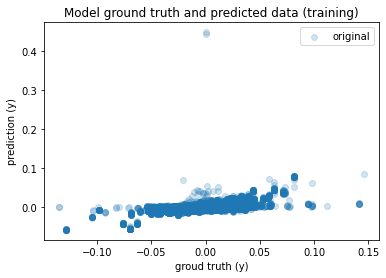

testing - R^2 score:  0.2958380622048449


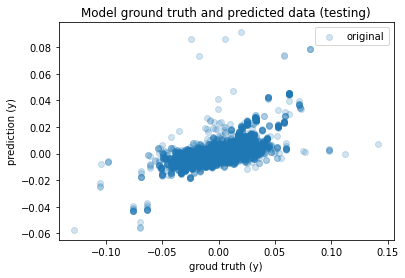

In [19]:
# plots results
plot_stats_regressor(model, X_train, y_train.fillna(0), test_name='training')
plot_stats_regressor(model, X_test, y_test.fillna(0), test_name='testing')

Apparently XGBoost is showing a tendency to Overfit the training data...

However results still look promissing.

Bitboy_Crypto - 3242 tweets
Bitboy_Crypto - full data - R^2 score:  0.2877682943504595


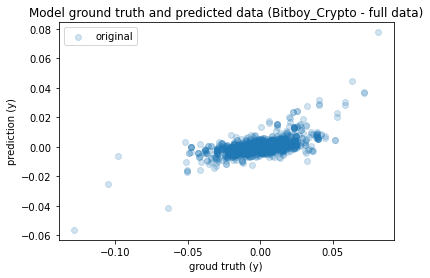

Bitboy_Crypto - train data - R^2 score:  0.2844081583279894


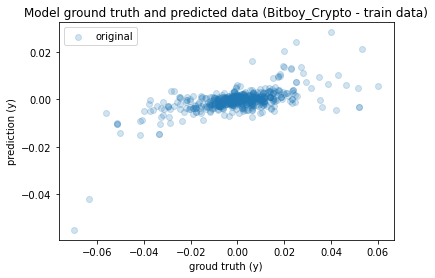

TheCryptoDog - 3245 tweets
TheCryptoDog - full data - R^2 score:  0.4673970466128836


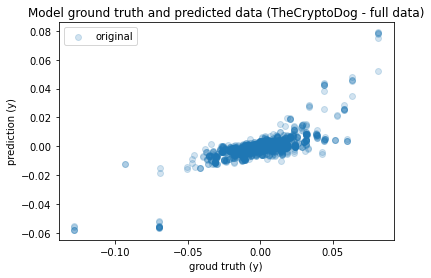

TheCryptoDog - train data - R^2 score:  0.43921210588343684


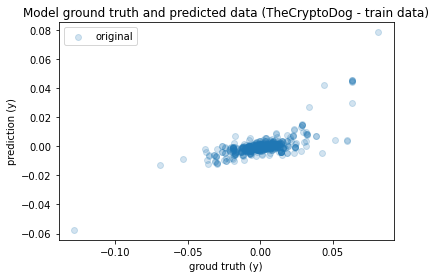

davidgokhshtein - 3450 tweets
davidgokhshtein - full data - R^2 score:  0.4053798445474124


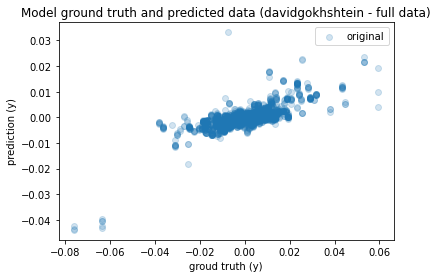

davidgokhshtein - train data - R^2 score:  0.3119445912076555


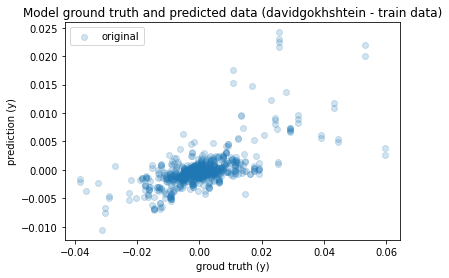

justinsuntron - 3406 tweets
justinsuntron - full data - R^2 score:  0.1778819526400529


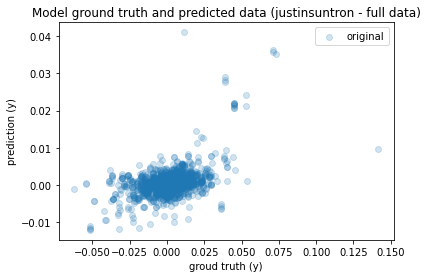

justinsuntron - train data - R^2 score:  0.1108683128601059


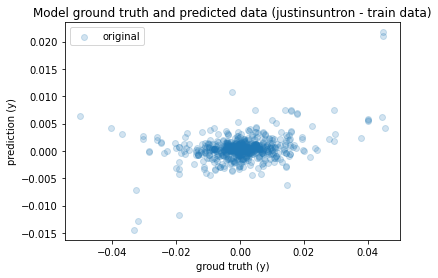

CryptoCobain - 3445 tweets
CryptoCobain - full data - R^2 score:  0.47128763915138894


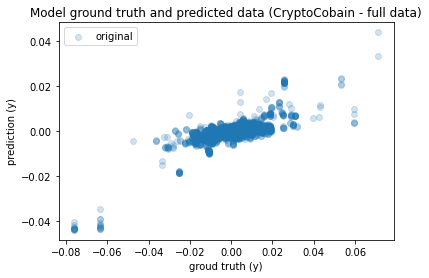

CryptoCobain - train data - R^2 score:  0.4664431245822849


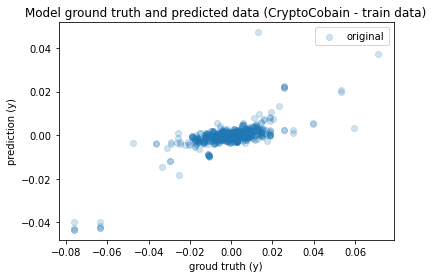

CryptoWendyO - 3436 tweets
CryptoWendyO - full data - R^2 score:  0.3397849750791986


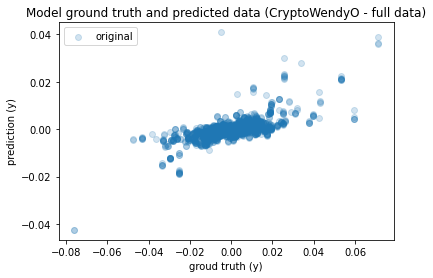

CryptoWendyO - train data - R^2 score:  0.31696110592317417


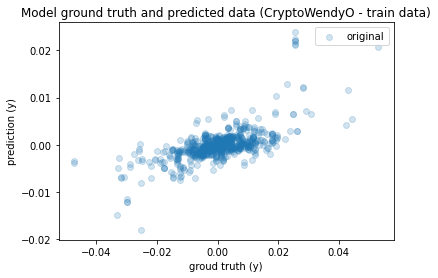

LayahHeilpern - 3246 tweets
LayahHeilpern - full data - R^2 score:  0.5007432519479753


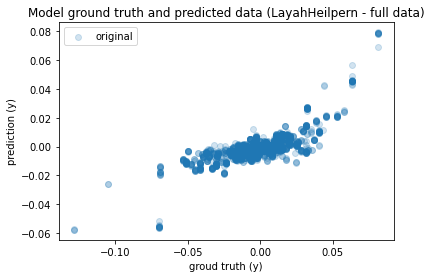

LayahHeilpern - train data - R^2 score:  0.4668043065325407


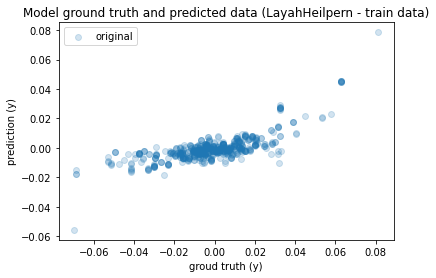

IvanOnTech - 3410 tweets
IvanOnTech - full data - R^2 score:  0.22308665074221046


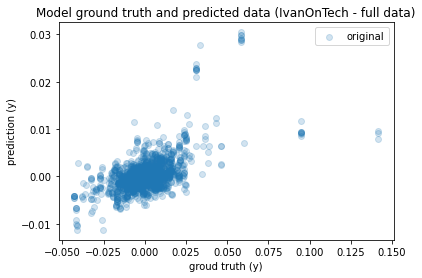

IvanOnTech - train data - R^2 score:  0.16270190317707167


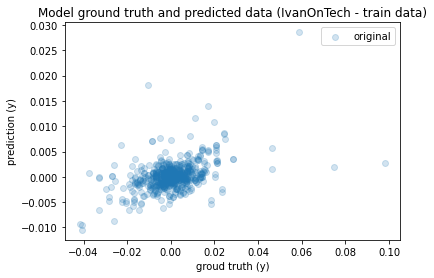

coinbureau - 2419 tweets
coinbureau - full data - R^2 score:  0.18985846194087197


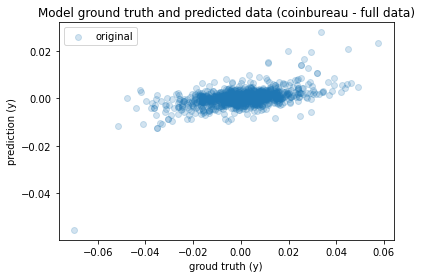

coinbureau - train data - R^2 score:  0.15116252054288237


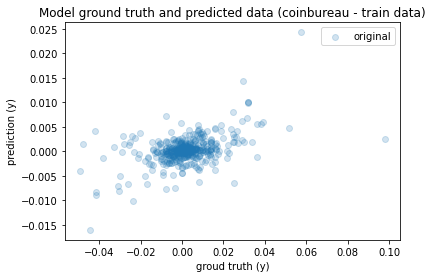

BarrySilbert - 1491 tweets
BarrySilbert - full data - R^2 score:  0.22490415926190988


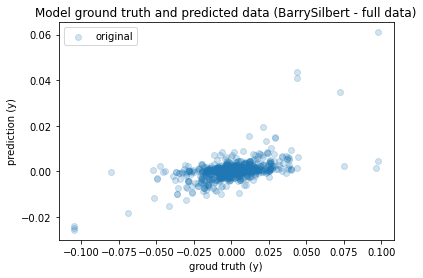

BarrySilbert - train data - R^2 score:  0.1010307481336058


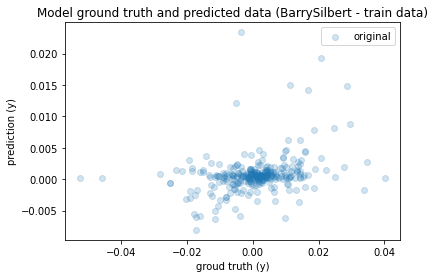

Cardano - 2150 tweets
Cardano - full data - R^2 score:  0.11150030743765427


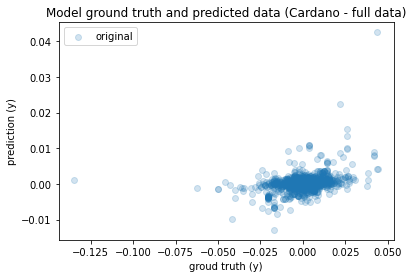

Cardano - train data - R^2 score:  0.15651030368397123


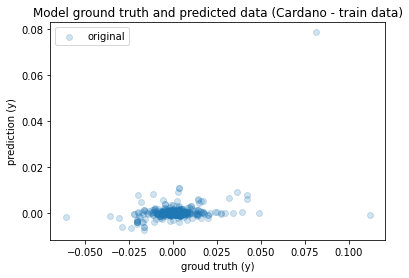

100trillionUSD - 2285 tweets
100trillionUSD - full data - R^2 score:  0.23627981736765036


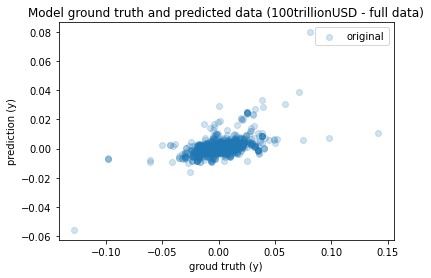

100trillionUSD - train data - R^2 score:  0.20182958900825898


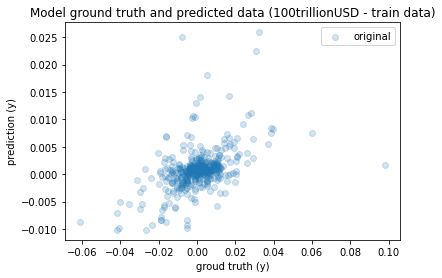

girlgone_crypto - 3448 tweets
girlgone_crypto - full data - R^2 score:  0.2892749877113211


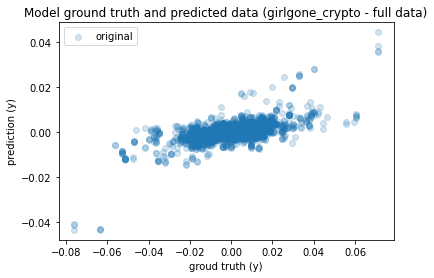

girlgone_crypto - train data - R^2 score:  0.2820863493526554


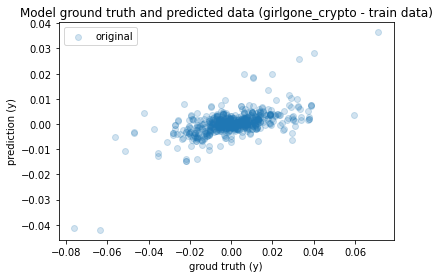

brian_armstrong - 332 tweets
brian_armstrong - full data - R^2 score:  0.15403948592120487


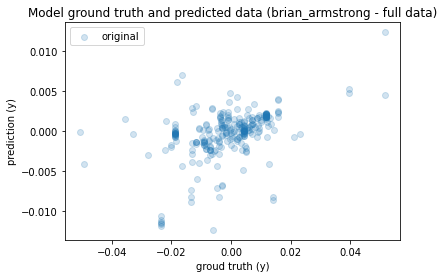

brian_armstrong - train data - R^2 score:  0.13442336972865498


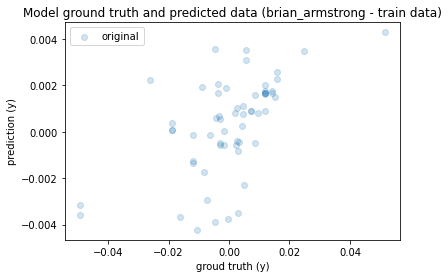

officialmcafee - 3235 tweets
officialmcafee - full data - R^2 score:  0.16474038493193865


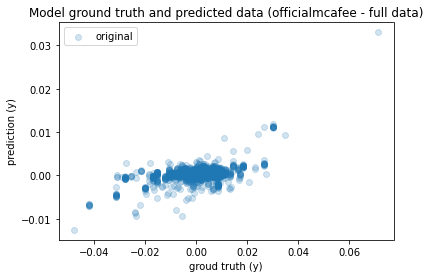

officialmcafee - train data - R^2 score:  0.16162572904158778


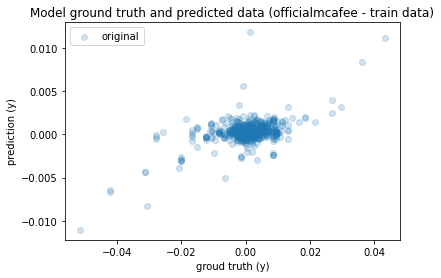

VitalikButerin - 3191 tweets
VitalikButerin - full data - R^2 score:  0.038939172639369635


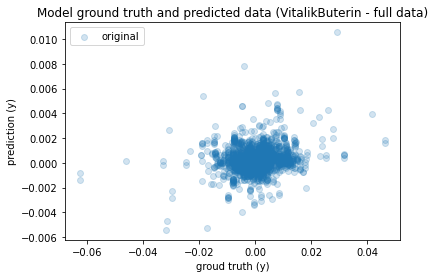

VitalikButerin - train data - R^2 score:  0.015468345191865573


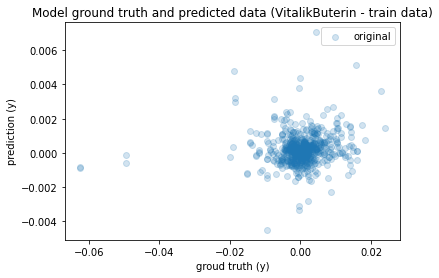

elonmusk - 3237 tweets
elonmusk - full data - R^2 score:  0.18687195786201793


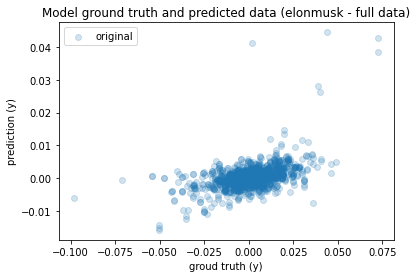

elonmusk - train data - R^2 score:  0.14935747430519686


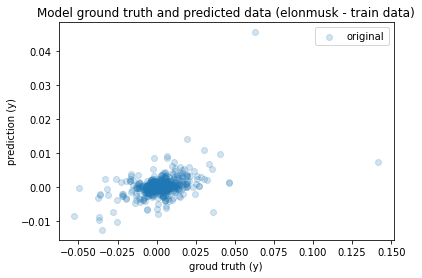

danheld - 3241 tweets
danheld - full data - R^2 score:  0.39066528065169215


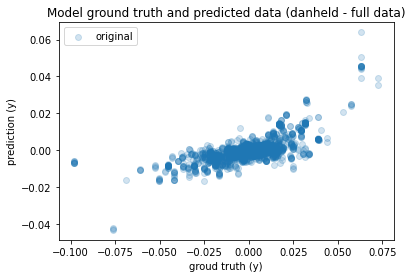

danheld - train data - R^2 score:  0.4116931662251627


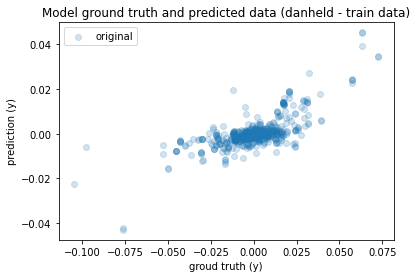

APompliano - 3449 tweets
APompliano - full data - R^2 score:  0.33752835889322685


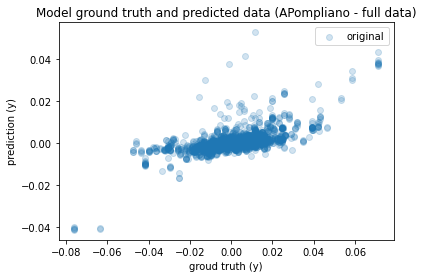

APompliano - train data - R^2 score:  0.1355783317871031


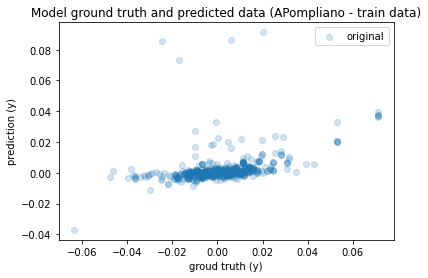

mysticaloaks - 3450 tweets
mysticaloaks - full data - R^2 score:  0.32340256880040663


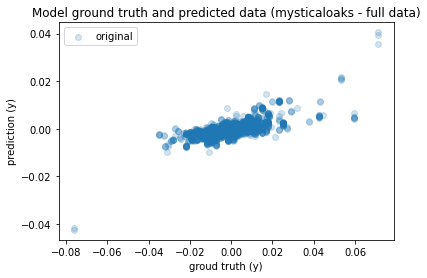

mysticaloaks - train data - R^2 score:  0.28796463636926617


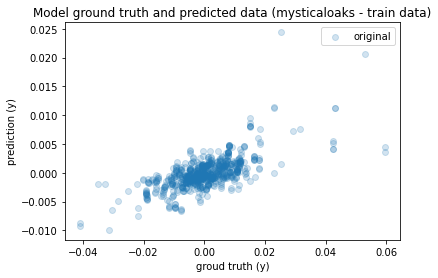

ToneVays - 3438 tweets
ToneVays - full data - R^2 score:  0.2094630449509024


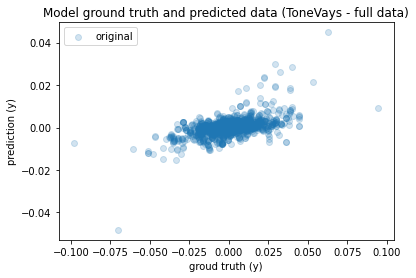

ToneVays - train data - R^2 score:  0.14798913104169942


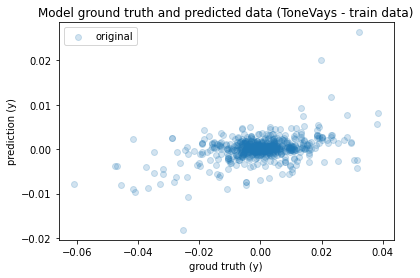

rogerkver - 575 tweets
rogerkver - full data - R^2 score:  0.07632602758879514


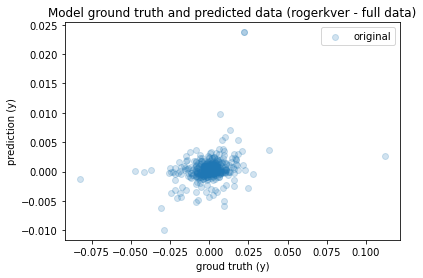

rogerkver - train data - R^2 score:  0.045813753027002524


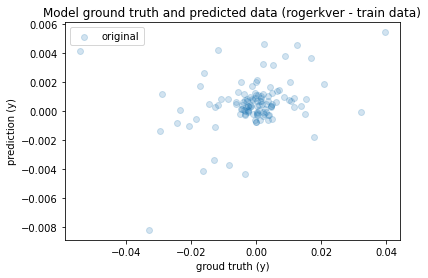

CryptoEuclid - 3341 tweets
CryptoEuclid - full data - R^2 score:  0.2930616321508511


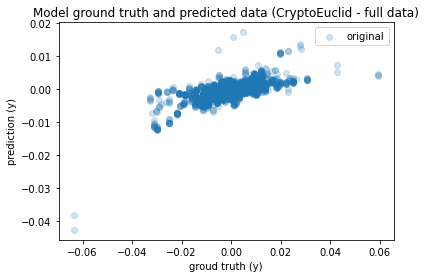

CryptoEuclid - train data - R^2 score:  0.28030582311795715


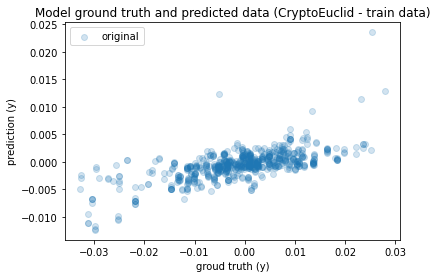

ErikVoorhees - 3447 tweets
ErikVoorhees - full data - R^2 score:  0.3061369147530728


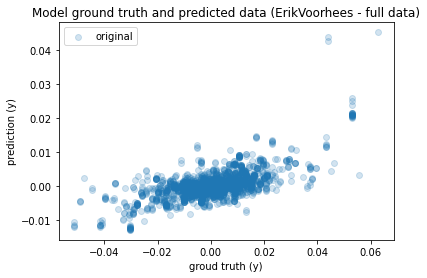

ErikVoorhees - train data - R^2 score:  0.27669816600097485


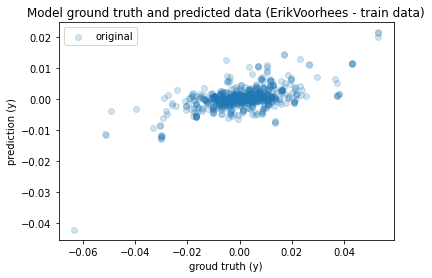

aantonop - 3316 tweets
aantonop - full data - R^2 score:  0.21011635830285258


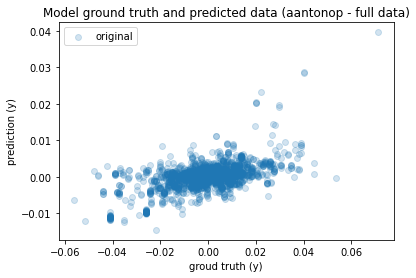

aantonop - train data - R^2 score:  0.15234439114173992


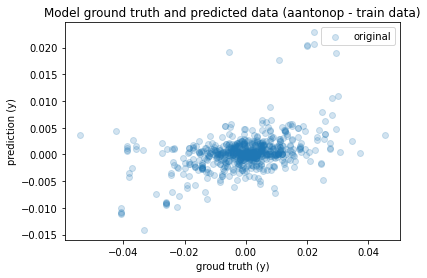

intocryptoverse - 1003 tweets
intocryptoverse - full data - R^2 score:  0.37451279240730395


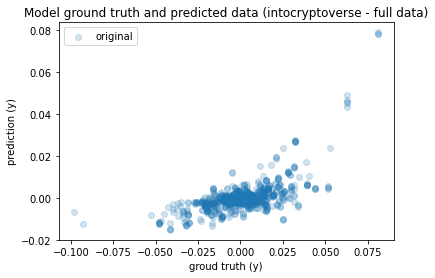

intocryptoverse - train data - R^2 score:  0.33420361971571877


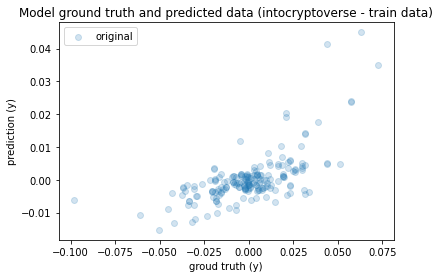

StackerSatoshi - 1444 tweets
StackerSatoshi - full data - R^2 score:  0.23622449360641629


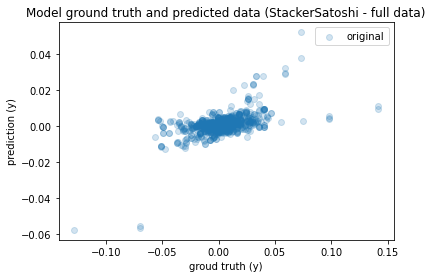

StackerSatoshi - train data - R^2 score:  0.1895224303489077


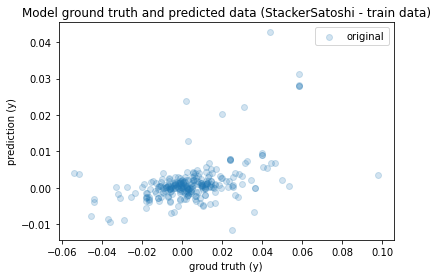

TheMoonCarl - 1184 tweets
TheMoonCarl - full data - R^2 score:  0.3738282334582109


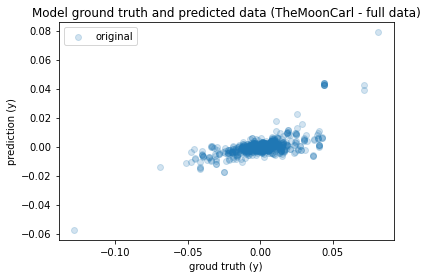

TheMoonCarl - train data - R^2 score:  0.32887910232991424


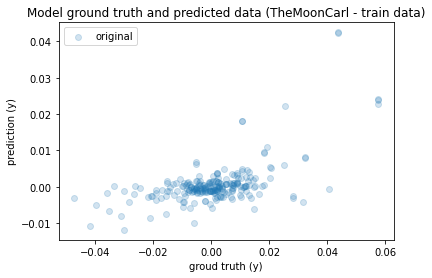

TyDanielSmith - 2367 tweets
TyDanielSmith - full data - R^2 score:  0.1315446698709034


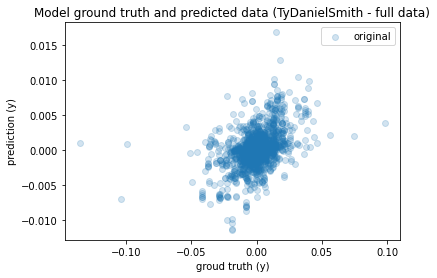

TyDanielSmith - train data - R^2 score:  0.20325637615713688


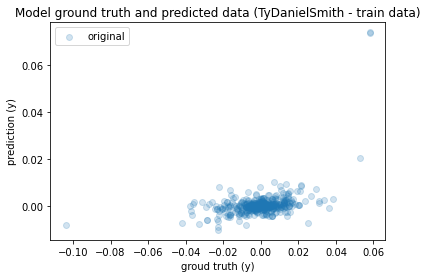

SatoshiLite - 2120 tweets
SatoshiLite - full data - R^2 score:  0.10107146798720945


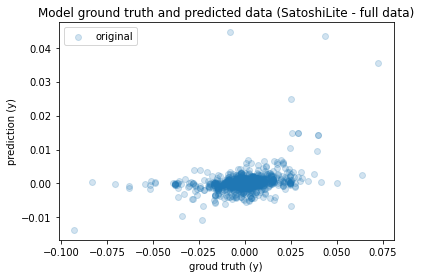

SatoshiLite - train data - R^2 score:  0.13613095568906775


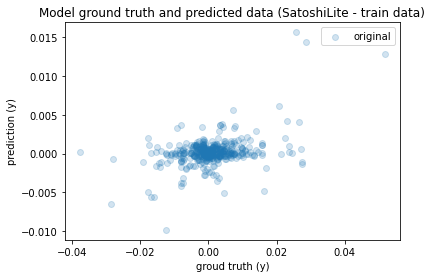

KennethBosak - 3450 tweets
KennethBosak - full data - R^2 score:  0.28547621981373894


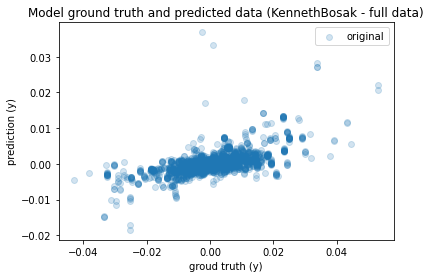

KennethBosak - train data - R^2 score:  0.37263388030840927


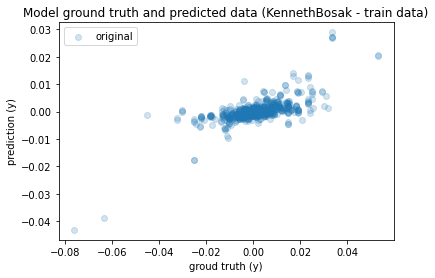

PeterMcCormack - 3240 tweets
PeterMcCormack - full data - R^2 score:  0.5293532200390748


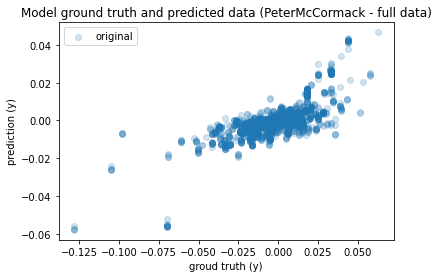

PeterMcCormack - train data - R^2 score:  0.5222393609404026


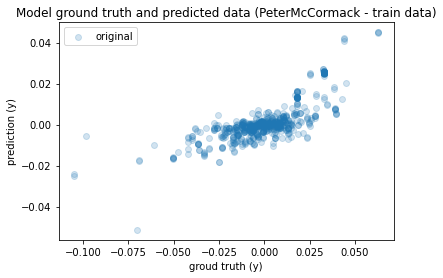

TimDraper - 572 tweets
TimDraper - full data - R^2 score:  0.311580602906651


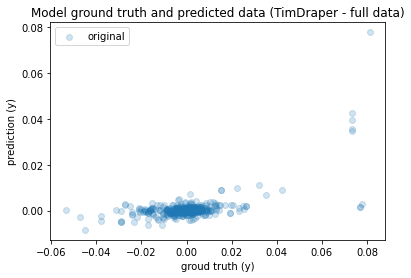

TimDraper - train data - R^2 score:  0.23214097476234252


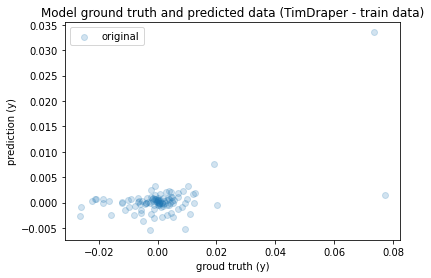

ethereum - 917 tweets
ethereum - full data - R^2 score:  0.09744700373228687


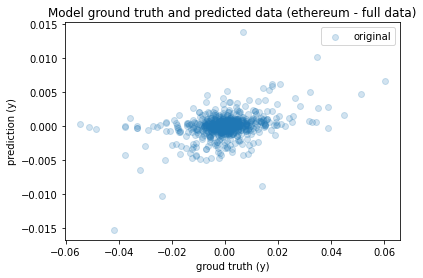

ethereum - train data - R^2 score:  0.10043278983829274


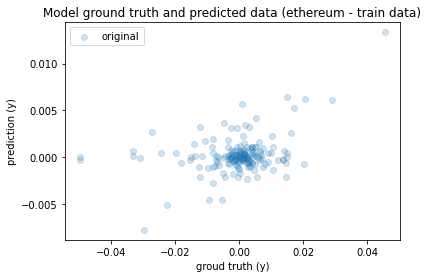

Coinbound_io - 882 tweets
Coinbound_io - full data - R^2 score:  0.27584381840636285


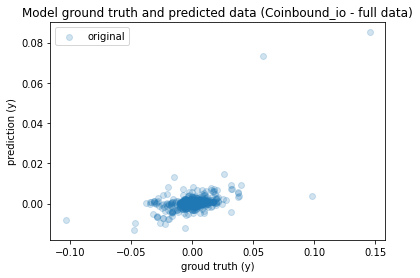

Coinbound_io - train data - R^2 score:  0.016741227925005542


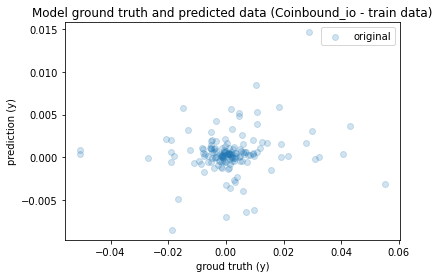

bhorowitz - 573 tweets
bhorowitz - full data - R^2 score:  0.27506561361154236


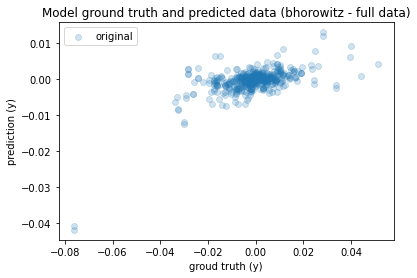

bhorowitz - train data - R^2 score:  0.33193229615132114


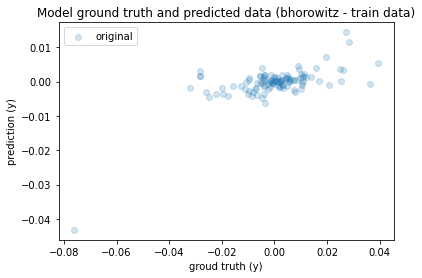

AltcoinDailyio - 650 tweets
AltcoinDailyio - full data - R^2 score:  -2.418665500324751


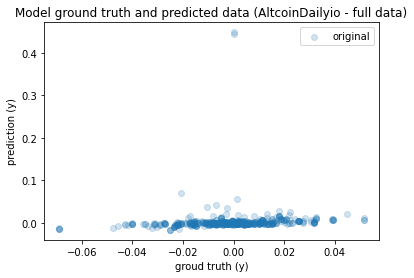

AltcoinDailyio - train data - R^2 score:  -0.045974099429898496


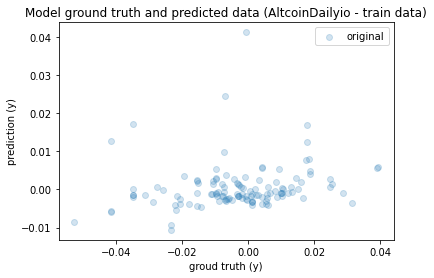

FEhrsam - 337 tweets
FEhrsam - full data - R^2 score:  0.21741229100936865


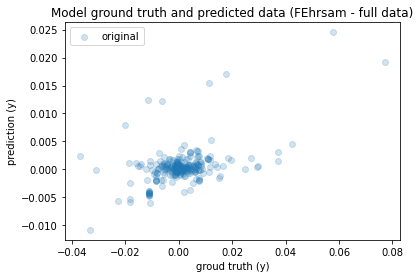

FEhrsam - train data - R^2 score:  -0.01741640921114973


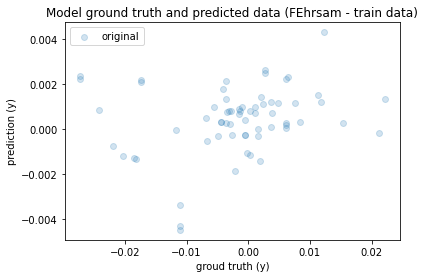

EuclidAndOaks - 317 tweets
EuclidAndOaks - full data - R^2 score:  0.06424614784473359


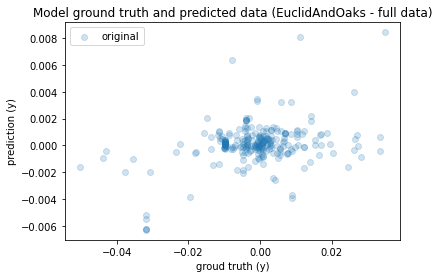

EuclidAndOaks - train data - R^2 score:  0.061933776781042504


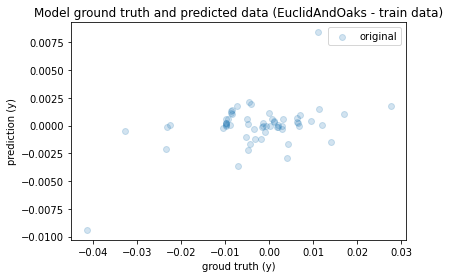

Cryptosrus - 73 tweets
Cryptosrus - full data - R^2 score:  0.21250793283501257


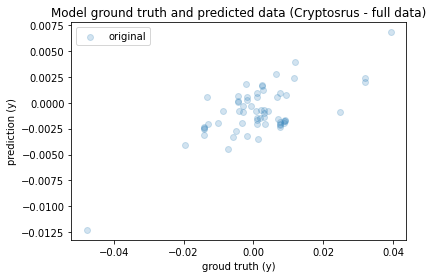

Cryptosrus - train data - R^2 score:  0.2402587850249155


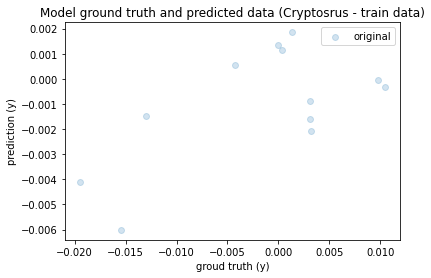

CryptoBrekkie - 3 tweets
CryptoBrekkie - full data - R^2 score:  -0.8531699631927478


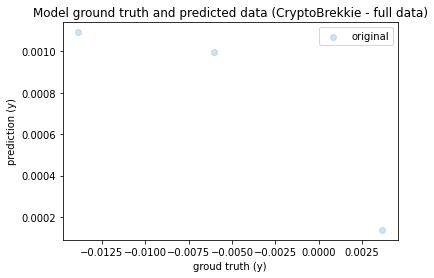

error Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Maxwell_Maher - 11 tweets
Maxwell_Maher - full data - R^2 score:  -0.28337116513188


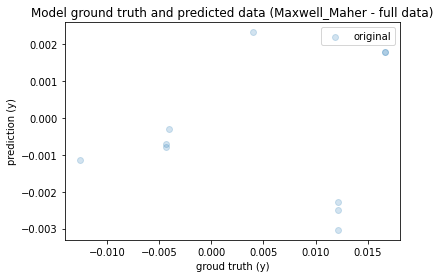

Maxwell_Maher - train data - R^2 score:  nan


c:\users\muril\.virtualenvs\crypto-prophet-ckjwbuny\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


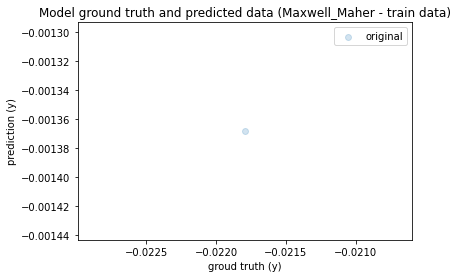

StackingUSD - 3 tweets
StackingUSD - full data - R^2 score:  0.04692125394177282


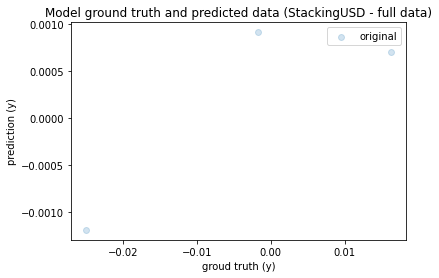

error Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [29]:
# plots results broken down per influencer
for u in X_train.user_feat.unique():
    mask = X_train.user_feat == u
    mask_test = X_test.user_feat == u
    user_screen_name = user_le.inverse_transform([u])[0]
    print(f"{user_screen_name} - {mask.sum() + mask_test.sum()} tweets")

    try:
        plot_stats_regressor(model, X_train[mask], y_train[mask].fillna(0), test_name=f"{user_screen_name} - full data")
        plot_stats_regressor(model, X_test[mask_test], y_test[mask_test].fillna(0), test_name=f"{user_screen_name} - train data")
    except Exception as e:
        print(f'error {e}')
        
    print(20*'=')

# Conclusion
> Model overall improved with addition of Technical Analysis KPI's, and other influencers show promissing results
>
> (eg. PeterMcCormack with R² score of  ~0.53).